In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *
from scripts.python.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

## Load, Merge

### Load Solomon Islands' Census

In [2]:
data_folder = os.getcwd() + "/data/tourism"
solomon_folder = data_folder + "/solomon/intermediate/"
solomon_monthly = [solomon_folder + file for file in os.listdir(solomon_folder) if "month" in file]

In [3]:
solomon = (pd.read_csv(solomon_monthly[0])
           .drop(["Unnamed: 0", "Total"], axis=1))
solomon = solomon.melt(id_vars="Year")

In [4]:
solomon["month"] = [datetime.strptime(
    str(mon), '%B').month for mon in solomon.variable]

solomon = (solomon.sort_values(["Year", "month"])
           .reset_index().drop(["index", "variable"], axis=1)
           .rename({"value": "total"}, axis=1))
solomon["date"] = [str(year) + "-" + str(month) for year, month in zip(solomon.Year, solomon.month)]
solomon["date"] = pd.to_datetime(solomon["date"])
solomon.head(5)

,Year,total,month,date
0,2009,1602,1,2009-01-01
1,2009,1422,2,2009-02-01
2,2009,1249,3,2009-03-01
3,2009,1499,4,2009-04-01
4,2009,1393,5,2009-05-01


### Load `owid-covid-data`

In [5]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))

solomon_si = (covid_si[covid_si.location == "Solomon Islands"]
              .reset_index()
              .drop("index", axis=1))
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si.head(5)

,location,date,stringency_index
0,Solomon Islands,2020-10-12,43.52
1,Solomon Islands,2020-10-13,43.52
2,Solomon Islands,2020-10-14,43.52
3,Solomon Islands,2020-10-15,43.52
4,Solomon Islands,2020-10-16,43.52


In [6]:
oceania_si = (covid_si.groupby("date").mean()
              .reset_index()
              .rename({"stringency_index": "oceania_index"}, axis=1))
oceania_si["date"] = pd.to_datetime(oceania_si["date"])

solomon_si = (oceania_si.merge(solomon_si, how="left", on="date")
              .drop("location", axis=1))

In [7]:
solomon_si["year"], solomon_si["month"] = \
    solomon_si["date"].dt.year, solomon_si["date"].dt.month
solomon_si = solomon_si.groupby(["year", "month"]).mean().reset_index()
solomon_si["date"] = [str(year) + "-" + str(month)
                      for year, month in zip(solomon_si.year, solomon_si.month)]
solomon_si["date"] = pd.to_datetime(solomon_si["date"])
solomon_si["covid"] = (solomon_si.date >= "2020-03-01").astype(int)
solomon_si = solomon_si.drop(["year", "month"], axis=1)

In [8]:
solomon = (solomon.merge(solomon_si, how="left", on="date")
           .fillna(0))
solomon.head(5)

,Year,total,month,date,oceania_index,stringency_index,covid
0,2009,1602,1,2009-01-01,0.0,0.0,0.0
1,2009,1422,2,2009-02-01,0.0,0.0,0.0
2,2009,1249,3,2009-03-01,0.0,0.0,0.0
3,2009,1499,4,2009-04-01,0.0,0.0,0.0
4,2009,1393,5,2009-05-01,0.0,0.0,0.0


In [9]:
solomon

,Year,total,month,date,oceania_index,stringency_index,covid
0,2009,1602,1,2009-01-01,0.000000,0.000000,0.0
1,2009,1422,2,2009-02-01,0.000000,0.000000,0.0
2,2009,1249,3,2009-03-01,0.000000,0.000000,0.0
3,2009,1499,4,2009-04-01,0.000000,0.000000,0.0
4,2009,1393,5,2009-05-01,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...
139,2020,39,8,2020-08-01,58.649274,0.000000,1.0
140,2020,103,9,2020-09-01,54.897750,0.000000,1.0
141,2020,60,10,2020-10-01,47.380065,43.520000,1.0
142,2020,16,11,2020-11-01,43.297800,43.026000,1.0


In [10]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_solomon_islands.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.columns = [col.replace(" ", "_") for col in gt.columns]
gt.head(5)

,date,solomon_islands_flights-AU,solomon_islands_hotel-AU,solomon_islands_travel-AU,solomon_islands_flights-NZ,solomon_islands_hotel-NZ,solomon_islands_travel-NZ,solomon_islands_flights-US,solomon_islands_hotel-US,solomon_islands_travel-US,...,solomon_islands_travel-JP,solomon_islands_flights-HK,solomon_islands_hotel-HK,solomon_islands_travel-HK,solomon_islands_flights-NC,solomon_islands_hotel-NC,solomon_islands_travel-NC,solomon_islands_flights,solomon_islands_hotel,solomon_islands_travel
0,2004-01-01,97,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,2.490457
1,2004-02-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.000000
2,2004-03-01,0,0,0,0,0,0,0,100,72,...,0,0,0,0,0,0,0,0.0,0.0,0.000000
3,2004-04-01,0,0,0,0,0,0,38,0,0,...,0,0,0,0,0,0,0,0.0,0.0,3.844978
4,2004-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.000000


In [53]:
solomon = solomon.merge(gt.iloc[:, [0,-3,-2,-1]], on="date", how="left")
solomon.to_csv(data_folder+"/solomon/intermediate/si_sarima_data.csv", encoding="utf-8")
solomon.head(5)

,Year,total,month,date,oceania_index,stringency_index,covid,solomon_islands_flights_x,solomon_islands_hotel_x,solomon_islands_travel_x,solomon_islands_flights_y,solomon_islands_hotel_y,solomon_islands_travel_y
0,2009,1602,1,2009-01-01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,2009,1422,2,2009-02-01,0.0,0.0,0.0,0.484667,0.0,0.203672,0.484667,0.0,0.203672
2,2009,1249,3,2009-03-01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,2009,1499,4,2009-04-01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,2009,1393,5,2009-05-01,0.0,0.0,0.0,0.000000,0.0,0.478020,0.000000,0.0,0.478020


## SARIMAX

In [12]:
get_adf_df(solomon, ["total"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-2.602577,0.092466,3.0,140.0,-3.477945,-2.882416,-2.577902


In [13]:
sb = SARIMAXPipeline(data=solomon, y_var="total",
                     exog_var=["covid", "stringency_index", "solomon_islands_travel"], transform_method="scaledlogit",
                     training_ratio=1)

training size : 144, testing size : 0


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=464.505, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=465.270, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=435.790, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=399.945, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=463.309, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=403.267, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=396.516, Time=0.34 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=398.606, Time=0.23 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=398.617, Time=0.61 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=398.458, Time=0.88 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=399.172, Time=0.52 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=400.749, Time=0.87 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=462.137, Time=0.23 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   

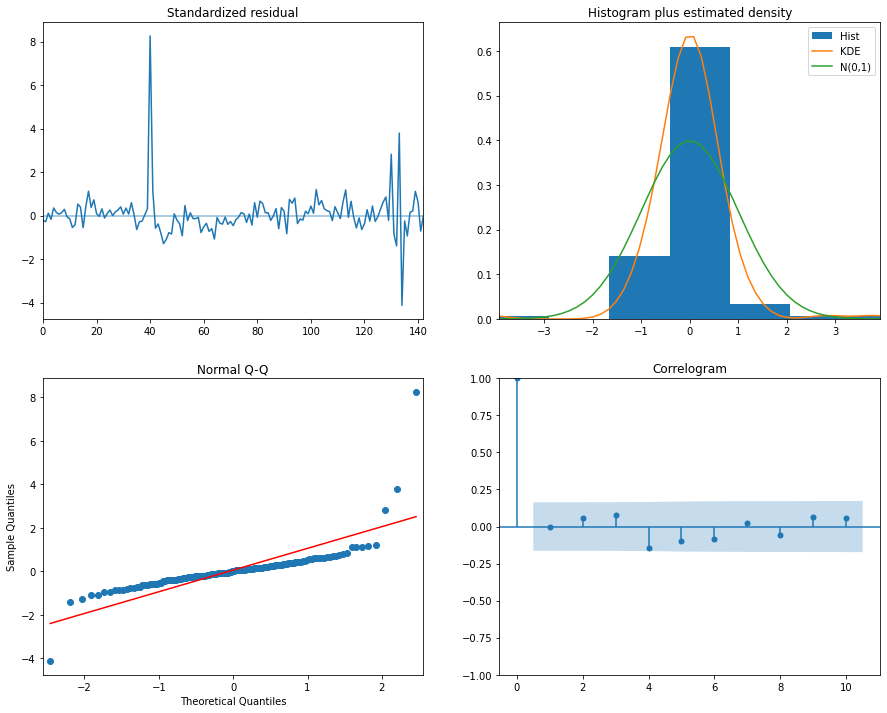

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [14]:
sb.transform()
sb.stepwise_search(d=1)

In [15]:
# Set parameter range
p, d, q = range(0, 3), [1], range(0, 3)
P, D, Q, s = range(0, 3), range(0,2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))
sb.manual_search(all_param)

Tried out SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC:463.31
Tried out SARIMAX(0, 1, 0)x(0, 0, 1, 12) - AIC:462.56
Tried out SARIMAX(0, 1, 0)x(0, 0, 2, 12) - AIC:463.51
Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 12) - AIC:477.43
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:438.72
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:440.72
Tried out SARIMAX(0, 1, 0)x(1, 0, 0, 12) - AIC:461.96
Tried out SARIMAX(0, 1, 0)x(1, 0, 1, 12) - AIC:460.17
Tried out SARIMAX(0, 1, 0)x(1, 0, 2, 12) - AIC:462.17
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 12) - AIC:454.93
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 12) - AIC:440.72
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:442.53
Tried out SARIMAX(0, 1, 0)x(2, 0, 0, 12) - AIC:462.65
Tried out SARIMAX(0, 1, 0)x(2, 0, 1, 12) - AIC:462.17
Tried out SARIMAX(0, 1, 0)x(2, 0, 2, 12) - AIC:463.94
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:448.0
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:442.53
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:444.47
Tried out SARIMAX(0, 1, 1)x(0

Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:402.83
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:385.12
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:388.0
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:401.9
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:400.6
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:402.87
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:396.73
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:387.87
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:389.47


[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1449742b0>,
  463.3094365930136,
  ((0, 1, 0), (0, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1459bd4f0>,
  462.5607209349662,
  ((0, 1, 0), (0, 0, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1459a4610>,
  463.5093672702021,
  ((0, 1, 0), (0, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x145b9dfd0>,
  477.43426276606084,
  ((0, 1, 0), (0, 1, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x145b84c70>,
  438.7218305928286,
  ((0, 1, 0), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x145963d00>,
  440.7177067981101,
  ((0, 1, 0), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x145bc6eb0>,
  461.9568423889903,
  ((0, 1, 0), (1, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x145be5f10>,
  460.1728955645130

In [16]:
sb_msres = sb.manual_search_results
sb_msres.sort(key=lambda x: x[1])
sb_msres

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147c82820>,
  377.8018567339962,
  ((0, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147ca1a60>,
  379.7176233209831,
  ((0, 1, 1), (0, 1, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147d41070>,
  379.74644316151694,
  ((0, 1, 1), (1, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147eb21c0>,
  379.76467326614227,
  ((0, 1, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x155bd6f10>,
  379.76810562621284,
  ((1, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x29f2d55b0>,
  381.4402728138257,
  ((2, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147dd41f0>,
  381.6738922212353,
  ((0, 1, 1), (2, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x155c18400>,
  381.70691157766

In [17]:
sb_sw = sb.stepwise_model
sb_models = []
sb_models.append(pm.ARIMA(
    sb_sw["order"], sb_sw["seasonal_order"],  exog=sb.exog[:sb.training_size]))

for res in sb_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=sb.exog[:sb.training_size])
    sb_models.append(model)
    
sb_comp = sb.compare_models(
    sb.transformed_y[:sb.training_size], sb.exog[:sb.training_size], sb_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................


In [18]:
sb_comp

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 2, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([138.71924106, 142.74309331,  53.98834048, 137.3447321 ,
         121.54140919, 183.59103361, 123.61658326, 124.11370714,
         146.63087515, 179.55195348,  92.77001783,  72.46710014,
          97.74395344, 103.83050404,  72.42907743,  60.89343149,
          65.25007123,  77.92932626,  46.07205896, 115.50981565,
         195.60302457]),
  array([159.80724452,  98.37306741,  70.67921348,  71.1075236 ,
         110.94142747, 174.81326148,  92.77735308, 100.57126033,
         162.33103548, 111.24591057, 117.57572166,  84.73178546,
          92.09423457,  82.47791175,  82.16014514,  45.95996208,
          57.38126791,  88.2151

In [19]:
best_ss = sb_msres[1][0]
best_ss_mod = best_ss.get_prediction().summary_frame()
best_ss_mod.columns.name = None
lower = solomon["total"].min() - 1
upper = solomon["total"].max() + 1

for col_idx, col in enumerate(best_ss_mod.columns):
    for row_idx, _ in enumerate(best_ss_mod[col]):
        best_ss_mod.iloc[row_idx, col_idx] = sb.inverse_scaledlogit(
            best_ss_mod.iloc[row_idx, col_idx], upper, lower)
        
best_ss_mod = pd.concat([solomon[["date", "total"]], best_ss_mod], axis=1)
best_ss_mod.head(20)

,date,total,mean,mean_se,mean_ci_lower,mean_ci_upper
0,2009-01-01,1602,1562.000000,NaN,1.000000,NaN
1,2009-02-01,1422,1638.235931,NaN,1.000000,NaN
2,2009-03-01,1249,1386.085605,NaN,1.000000,NaN
3,2009-04-01,1499,1249.000169,NaN,1.000000,NaN
4,2009-05-01,1393,1584.131879,NaN,1.000000,NaN
5,2009-06-01,1724,1351.963450,NaN,1.000000,NaN
6,2009-07-01,1603,1715.535109,NaN,1.000000,NaN
7,2009-08-01,1520,1568.046726,NaN,1.000000,NaN
8,2009-09-01,1659,1587.861744,NaN,1.000000,NaN
9,2009-10-01,1709,1591.247438,NaN,1.000000,NaN


Text(0.5, 1.0, "Solomon Islands' Visitor Arrivals")

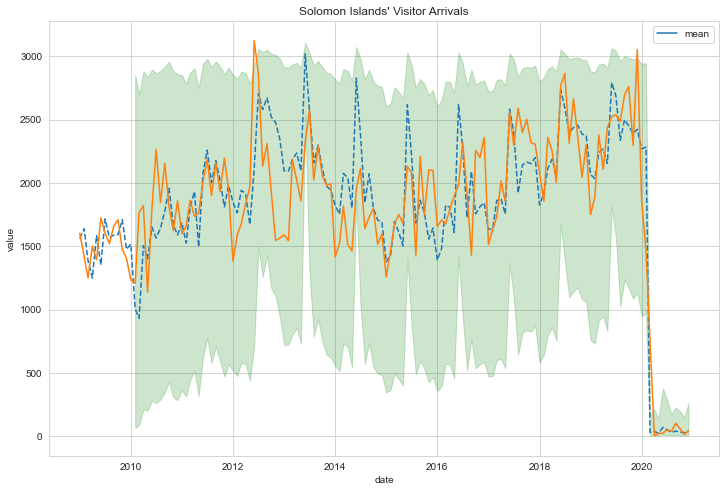

In [20]:
viz_df = best_ss_mod[["date", "mean"]].melt(id_vars=["date"])
viz_df["date"] = pd.to_datetime(viz_df["date"])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=best_ss_mod, x="date", y="total")
ax.fill_between(data=best_ss_mod, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2, color="green")
plt.title("Solomon Islands' Visitor Arrivals")

In [21]:
naive_pred = naive_method(solomon["total"])
mean_pred = mean_method(solomon["total"])
snaive_pred = seasonal_naive_method(solomon["total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(solomon["total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,MAPE
naive,130146.048951,360.757604,273.083916,281.140723
mean,373388.932822,611.055589,428.780575,949.016710
seasonal naive,719201.125000,848.057265,537.375000,1173.239234


In [50]:
sl_eval = pd.DataFrame(calculate_evaluation(solomon["total"], best_ss_mod["mean"]), index=["scaled logit"])
mod_eval = pd.concat([benchmark, sl_eval], axis=0)
mod_eval.to_csv(data_folder+"/solomon/model/si_utsa_eval.csv", encoding="utf-8")
mod_eval

,MSE,RMSE,MAE,MAPE
naive,130146.048951,360.757604,273.083916,281.140723
mean,373388.932822,611.055589,428.780575,949.016710
seasonal naive,719201.125000,848.057265,537.375000,1173.239234
scaled logit,105455.089733,324.738494,239.169298,28.342797


## VARMAX

In [52]:
merged_path = [solomon_folder +
               file for file in os.listdir(solomon_folder) if "merged" in file]
sb_merged = pd.read_csv(merged_path[0]).drop("Unnamed: 0", axis=1)
sb_merged["date"] = [str(y) + "-" + str(m)
                     for y, m in zip(sb_merged.Year, sb_merged.Month)]
sb_merged["date"] = pd.to_datetime(sb_merged["date"])
sb_merged = sb_merged.merge(solomon_si, on="date", how="left").fillna(0)
sb_merged = sb_merged.merge(gt.iloc[:, [0, -3, -2, -1]], how="left", on="date")
sb_merged.columns = [col.lower() for col in sb_merged.columns]
sb_merged.to_csv(data_folder+"/solomon/intermediate/si_var_data.csv", encoding="utf-8")
sb_merged.head(5)

,year,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,total,date,oceania_index,stringency_index,covid,solomon_islands_flights,solomon_islands_hotel,solomon_islands_travel
0,2019,1,69.0,69.0,10036.0,10036.0,1750.0,2019-01-01,0.0,0.0,0.0,0.112184,0.087288,0.262692
1,2019,2,66.0,66.0,9471.0,9471.0,1891.0,2019-02-01,0.0,0.0,0.0,0.094343,0.180838,0.194975
2,2019,3,69.0,71.0,9693.0,9965.0,2378.0,2019-03-01,0.0,0.0,0.0,0.197474,0.000000,0.099021
3,2019,4,66.0,71.0,9532.0,10212.0,2106.0,2019-04-01,0.0,0.0,0.0,0.275503,0.100638,0.070665
4,2019,5,69.0,73.0,9859.0,10403.0,2434.0,2019-05-01,0.0,0.0,0.0,0.266857,0.227301,0.211019


In [24]:
select_cols = ["total", "seats_arrivals_intl", "solomon_islands_travel"]
get_adf_df(sb_merged, select_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-0.451626,0.901116,0.0,23.0,-3.752928,-2.998500,-2.638967
seats_arrivals_intl,-0.559959,0.879775,9.0,14.0,-4.012034,-3.104184,-2.690987
solomon_islands_travel,-2.403872,0.140647,9.0,14.0,-4.012034,-3.104184,-2.690987


In [25]:
sb_diff = sb_merged[select_cols].diff().dropna()
sb_diff2 = sb_diff[select_cols].diff().dropna()
get_adf_df(sb_diff2, select_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-10.592363,6.478634e-19,0.0,21.0,-3.788386,-3.013098,-2.646397
seats_arrivals_intl,-12.078784,2.257563e-22,0.0,21.0,-3.788386,-3.013098,-2.646397
solomon_islands_travel,1.629642,9.979438e-01,9.0,12.0,-4.137829,-3.154972,-2.714477


In [26]:
varma_res = varma_search(sb_diff2, select_cols, sb_merged[["stringency_index", "covid"]][2:])

 Running for {'p': 1, 'q': 1, 'tr': 'n'}
 Running for {'p': 1, 'q': 1, 'tr': 'c'}
 Running for {'p': 1, 'q': 1, 'tr': 't'}
 Running for {'p': 1, 'q': 1, 'tr': 'ct'}
 Running for {'p': 1, 'q': 2, 'tr': 'n'}
 Running for {'p': 1, 'q': 2, 'tr': 'c'}
 Running for {'p': 1, 'q': 2, 'tr': 't'}
 Running for {'p': 1, 'q': 2, 'tr': 'ct'}
 Running for {'p': 1, 'q': 3, 'tr': 'n'}
 Running for {'p': 1, 'q': 3, 'tr': 'c'}
 Running for {'p': 1, 'q': 3, 'tr': 't'}
 Running for {'p': 1, 'q': 3, 'tr': 'ct'}
 Running for {'p': 2, 'q': 1, 'tr': 'n'}
 Running for {'p': 2, 'q': 1, 'tr': 'c'}
 Running for {'p': 2, 'q': 1, 'tr': 't'}
 Running for {'p': 2, 'q': 1, 'tr': 'ct'}
 Running for {'p': 2, 'q': 2, 'tr': 'n'}
 Running for {'p': 2, 'q': 2, 'tr': 'c'}
 Running for {'p': 2, 'q': 2, 'tr': 't'}
 Running for {'p': 2, 'q': 2, 'tr': 'ct'}
 Running for {'p': 2, 'q': 3, 'tr': 'n'}
 Running for {'p': 2, 'q': 3, 'tr': 'c'}
 Running for {'p': 2, 'q': 3, 'tr': 't'}
 Running for {'p': 2, 'q': 3, 'tr': 'ct'}
 Running f

In [27]:
varma_res_df = pd.DataFrame(varma_res).sort_values(by="result").reset_index().drop("index", axis=1)
varma_res_df.head(5)

,model,result
0,"(1, 2, n)",729.228270
1,"(1, 1, n)",732.284028
2,"(3, 1, c)",732.647306
3,"(1, 1, c)",735.021710
4,"(2, 1, n)",735.030531


In [28]:
from statsmodels.tsa.api import VARMAX
varma = VARMAX(endog=sb_diff2[["total", "seats_arrivals_intl"]],
               exog= sb_merged[["stringency_index", "covid"]][2:], order=(1, 2), tr="n")
varma_res = varma.fit(disp=False)
varma_res.summary()

Dep. Variable:,"['total', 'seats_arrivals_intl']",No. Observations:,22
Model:,"VARMAX(1,2)",Log Likelihood,-346.720
,+ intercept,AIC,735.441
Date:,"Mon, 10 Apr 2023",BIC,758.352
Time:,15:19:56,HQIC,740.838
Sample:,0,,
,- 22,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.40, 0.06",Jarque-Bera (JB):,"0.53, 0.71"
Prob(Q):,"0.24, 0.81",Prob(JB):,"0.77, 0.70"
Heteroskedasticity (H):,"0.13, 1.05",Skew:,"0.16, 0.22"


In [29]:
total_pred = varma_res.get_prediction().summary_frame()
total_pred.columns.name = None
inv = np.cumsum(np.cumsum(total_pred["mean"]) + (sb_diff["total"][1])) + sb_merged["total"][1]
total_pred["mean"] = inv
total_pred

,mean,mean_se,mean_ci_lower,mean_ci_upper
2,1974.593676,777.200876,-1580.692050,1465.879401
3,1731.527792,576.730403,-1457.030378,803.711259
4,1921.498724,503.963734,-554.713953,1420.787585
5,1847.197542,466.518142,-1178.630872,650.086643
6,1379.011386,455.966877,-1287.563631,499.793684
7,1023.349851,440.506524,-750.852302,975.901544
8,464.261120,439.040511,-1063.930784,657.076393
9,-412.274874,433.687680,-1167.459496,532.564969
10,-1568.320583,433.672073,-1129.491358,570.471929
11,-2108.553583,432.123764,-231.134305,1462.759723


<AxesSubplot:xlabel='date', ylabel='value'>

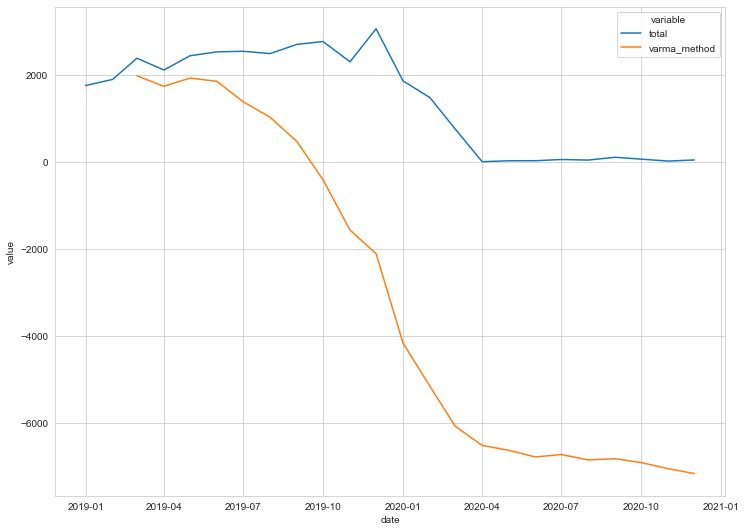

In [30]:
varma_pred = (pd.concat([sb_merged[["date", "total"]], total_pred[["mean"]]], axis=1)
              .rename({"mean": "varma_method"}, axis=1))
varma_viz_df = varma_pred.melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=varma_viz_df, x="date", y="value", hue="variable")

In [31]:
varma_pred["mean_method"] = mean_method(varma_pred["total"])
varma_pred["naive_method"] = naive_method(varma_pred["total"])

varma_eval = pd.DataFrame()
for col in varma_pred.columns:
    if "method" in col:
        method_row = pd.DataFrame(calculate_evaluation(
            varma_pred["total"], varma_pred[col]), index=[col])
        varma_eval = pd.concat([varma_eval, method_row], axis=0)
        
varma_eval

,MSE,RMSE,MAE,MAPE
varma_method,2.782705e+07,5275.135036,4557.253163,22551.737704
mean_method,1.290167e+06,1135.855000,1065.215278,4290.974992
naive_method,1.721267e+05,414.881597,268.478261,1671.938211


## Ratio Approach

In [32]:
sb_merged["ratio"] = sb_merged["total"]/sb_merged["seats_arrivals_intl"]
sb_merged["quarter"] = sb_merged["date"].dt.quarter
get_adf_df(sb_merged, ["ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
ratio,-0.314284,0.923457,1.0,22.0,-3.769733,-3.005426,-2.642501


In [33]:
import statsmodels.formula.api as smf
temp = sb_merged[["ratio", "covid", "oceania_index", "quarter", "solomon_islands_travel"]]
res = smf.wls(
    formula="ratio ~ covid * oceania_index + C(quarter) + solomon_islands_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.914
Model:                            WLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     24.15
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           2.27e-07
Time:                        15:19:56   Log-Likelihood:                 49.987
No. Observations:                  24   AIC:                            -83.97
Df Residuals:                      16   BIC:                            -74.55
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1963      0.034      5.811      0.000       0.125       0.268
C(quarter)[T.2]            0.0331      0.029      1.152      0.266      -0.028       0.094
C(quarter)[T.3]            0.0478      0.024      1.965      0.067      -0.004       0.099
C(quarter)[T.4]            0.0255      0.025      1.027      0.320      -0.027       0.078
covid                     -0.1505      0.066     -2.285      0.036      -0.290      -0.011
oceania_index             -0.0010      0.002     -0.416      0.683      -0.006       0.004
covid:oceania_index     6.657e-05      0.003      0.024      0.981      -0.006       0.006
solomon_islands_travel     0.1212      0.141      0.862      0.401      -0.177       0.419
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.318
Skew:                           0.250   Prob(JB):                        0.853
Kurtosis:                       2.739   Cond. No.                         972.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)
ratio_stats.head(5)

,ratio,covid,oceania_index,quarter,solomon_islands_travel,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.174372,0.0,0.0,1,0.262692,0.228173,0.020105,0.185553,0.270793,0.139054,0.317292
1,0.199662,0.0,0.0,1,0.194975,0.219966,0.018255,0.181266,0.258665,0.132654,0.307278
2,0.245332,0.0,0.0,1,0.099021,0.208336,0.023307,0.158927,0.257745,0.115778,0.300894
3,0.220940,0.0,0.0,2,0.070665,0.238044,0.019513,0.196679,0.279409,0.149519,0.326570
4,0.246881,0.0,0.0,2,0.211019,0.255055,0.023339,0.205578,0.304532,0.162461,0.347649


In [35]:
colnames_mean = [col for col in ratio_stats.columns if col.startswith('mean')]
for col in colnames_mean:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "predicted")
        sb_merged[colname] = sb_merged["seats_arrivals_intl"] * ratio_stats[col]

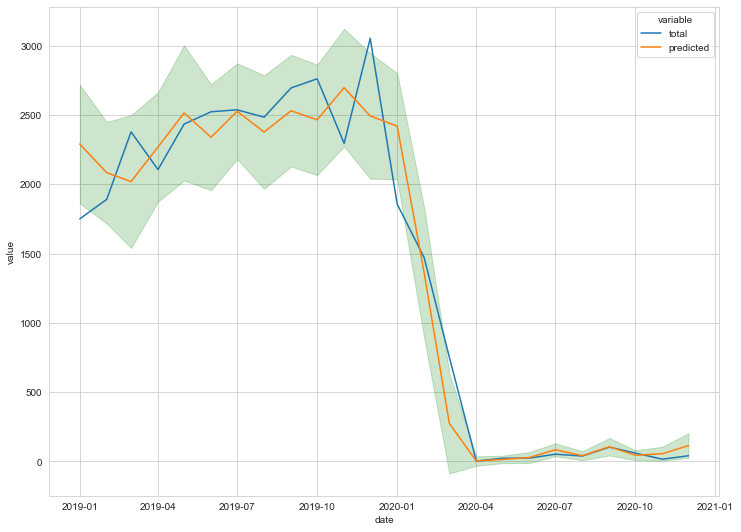

In [36]:
viz_df = sb_merged[["date", "total", "predicted"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=sb_merged, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
plt.show()

In [49]:
ratio_eval = pd.DataFrame(calculate_evaluation(
    sb_merged["total"], sb_merged["predicted"]), index=["ratio_method"])
ratio_eval = pd.concat([ratio_eval, varma_eval], axis=0)
ratio_eval.to_csv(data_folder+"/solomon/model/si_mtsa_eval.csv", encoding="utf-8")
ratio_eval

,MSE,RMSE,MAE,MAPE
ratio_method,7.042802e+04,265.382776,182.767003,35.516059
varma_method,2.782705e+07,5275.135036,4557.253163,22551.737704
mean_method,1.290167e+06,1135.855000,1065.215278,4290.974992
naive_method,1.721267e+05,414.881597,268.478261,1671.938211


### Future Forecasting

In [38]:
solomon_si_fu = (solomon_si[solomon_si.date >="2021-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (solomon_si_fu.merge(
    gt[["date", "solomon_islands_flights", "solomon_islands_travel"]],
    how="left", on="date"))
temp_fu["covid"] = (temp_fu.date >= "2020-03-12")
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu

,oceania_index,stringency_index,date,covid,solomon_islands_flights,solomon_islands_travel,quarter
0,41.731237,33.330000,2021-01-01,True,0.077367,0.116740,1
1,41.899583,33.330000,2021-02-01,True,0.126842,0.000000,1
2,41.022742,33.330000,2021-03-01,True,0.174213,0.067311,1
3,41.708619,32.219333,2021-04-01,True,0.228631,0.177929,2
4,40.110092,25.000000,2021-05-01,True,0.074375,0.083363,2
5,42.542000,25.000000,2021-06-01,True,0.188133,0.184996,2
6,43.060726,30.376774,2021-07-01,True,0.141392,0.219227,3
7,50.727782,38.890000,2021-08-01,True,0.158122,0.060973,3
8,53.614417,32.594333,2021-09-01,True,0.118315,0.111711,3
9,52.584032,27.780000,2021-10-01,True,0.120201,0.095411,4


In [39]:
future = res.get_prediction(temp).summary_frame()
future["date"] = temp_fu["date"]

In [40]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

sb_avi = (aviation[(aviation.ISO == "SB") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
sb_avi["Date"] = pd.to_datetime(sb_avi["Date"])
sb_avi["Month"], sb_avi["Year"] = sb_avi["Date"].dt.month, sb_avi["Date"].dt.year
sb_avi = sb_avi.groupby(["Year", "Month"]).sum().reset_index()
sb_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(sb_avi.Year, sb_avi.Month)]
sb_avi["date"] = pd.to_datetime(sb_avi["date"])
sb_avi_future = sb_avi[sb_avi.date >= "2021-01-01"].reset_index().drop("index", axis=1)
sb_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2021,1,1408,1408,2021-01-01
1,2021,2,1640,1640,2021-02-01
2,2021,3,1632,1632,2021-03-01
3,2021,4,2164,2164,2021-04-01
4,2021,5,1292,1444,2021-05-01


In [54]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "predicted")
        future[colname] = sb_avi_future["Seats_arrivals_intl"] * future[col]
future.head(5)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,predicted,predicted_ci_lower,predicted_ci_upper
0,0.228173,0.020105,0.185553,0.270793,0.139054,0.317292,2021-01-01,321.267593,261.258629,381.276556
1,0.219966,0.018255,0.181266,0.258665,0.132654,0.307278,2021-02-01,360.743985,297.276968,424.211002
2,0.208336,0.023307,0.158927,0.257745,0.115778,0.300894,2021-03-01,340.004835,259.369286,420.640384
3,0.238044,0.019513,0.196679,0.279409,0.149519,0.326570,2021-04-01,515.127965,425.614333,604.641597
4,0.255055,0.023339,0.205578,0.304532,0.162461,0.347649,2021-05-01,329.531224,265.607094,393.455354


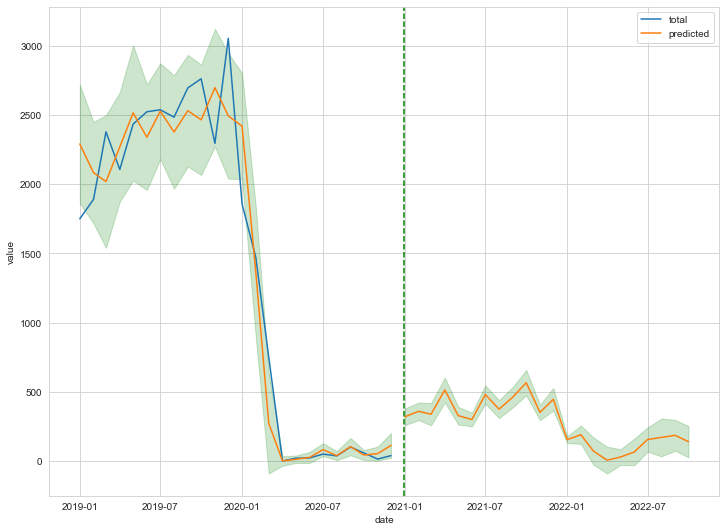

In [42]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(data=viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=sb_merged, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
sns.lineplot(data=future, x="date", y="predicted")
ax.fill_between(data=future, x="date", y1="predicted_ci_lower",
                y2="predicted_ci_upper", alpha=0.2, color="green")
plt.axvline(datetime(2020, 12, 31), linestyle="--", color="green")
plt.show()